In [1]:
%matplotlib inline
%config IPython.matplotlib.backend = "retina"
import matplotlib.pyplot as plt
from matplotlib import rcParams
rcParams["figure.dpi"] = 150
rcParams["savefig.dpi"] = 150
rcParams["text.usetex"] = True

In [2]:
import numpy as np
import math
import scipy.special as sps
from scipy.stats import nakagami

## Nakagami Likelihood

In [3]:
omega = 1.

In [4]:
nu = .65

In [5]:
h = nakagami.rvs(nu=nu, size=100000)

In [6]:
n = len(h)

In [7]:
def negloglikelihood(m):
    return - (len(h) * (m *(np.log(m) - np.log(omega)) - np.log(sps.gamma(m)))
              - m *(np.sum(h ** 2) / omega - 2 * np.sum(np.log(h))))

In [8]:
m = np.linspace(.5, 6., 1000)

In [9]:
ll = negloglikelihood(m)

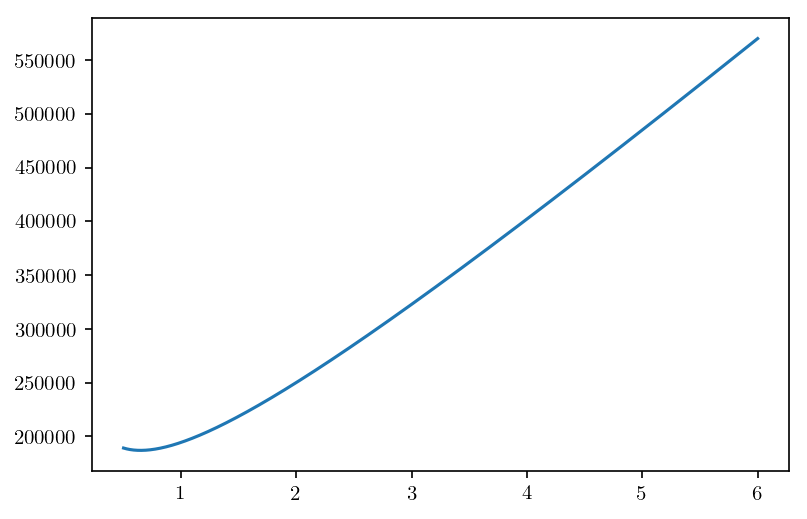

In [10]:
plt.plot(m, ll)

In [11]:
m[np.argmin(ll)]

0.64864864864864868

## Lower bound for $m \log m$

In [12]:
mt = 2.

In [13]:
dmlogm = m * (np.log(mt) + 1) - mt

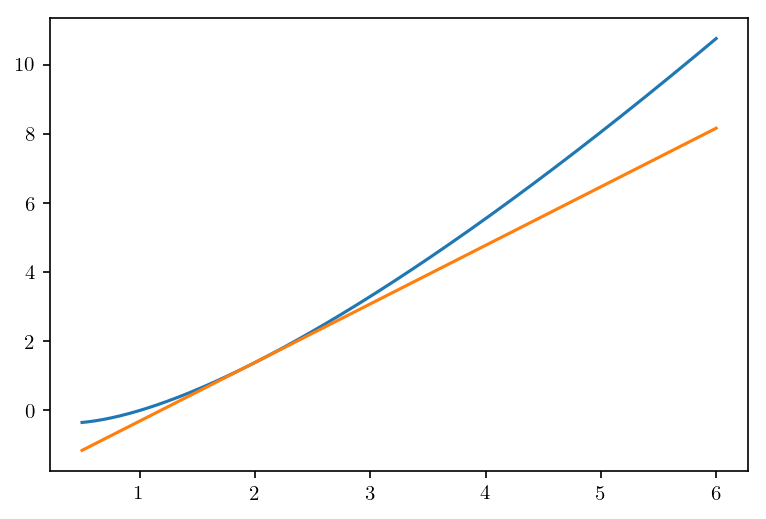

In [14]:
plt.plot(m, m * np.log(m))
plt.plot(m, dmlogm)

## Lower bound for $-\log\Gamma(m)$

In [15]:
f = np.log(sps.gamma(m))

In [16]:
p = sps.polygamma(1, .5)

In [17]:
g = np.log(sps.gamma(mt)) + sps.digamma(mt) * (m - mt) + .5*p * (m - mt) ** 2

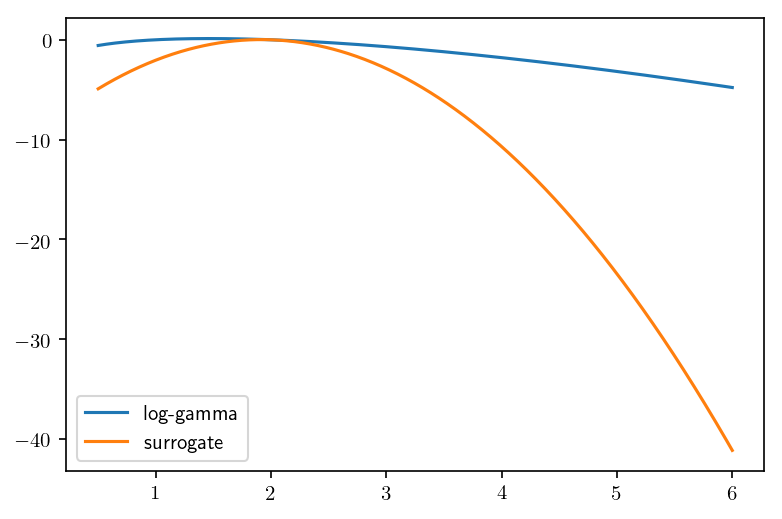

In [18]:
plt.plot(m, -f, label='log-gamma')
plt.plot(m, -g, label='surrogate')
plt.legend()

In [19]:
def surrogate(m, mt):
    return -(len(h) * (m * (np.log(mt) + 1) - mt - m * np.log(omega)
                       - (np.log(sps.gamma(mt)) + sps.digamma(mt) * (m - mt) + p * .5 * (m - mt) ** 2))
              - m *(np.sum(h ** 2) / omega - 2 * np.sum(np.log(h))))

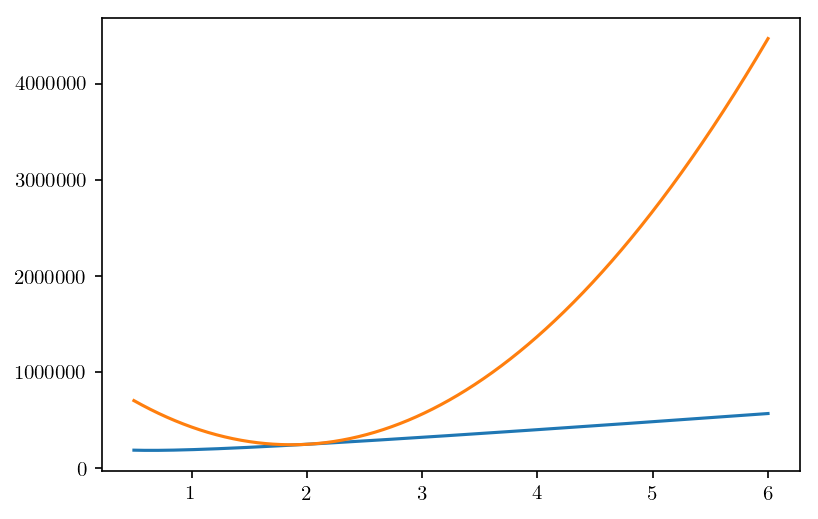

In [20]:
plt.plot(m, ll)
plt.plot(m, surrogate(m, mt))

It's correct!

## Surrogate function minimizer

In [73]:
def m_estimator(h, mt):
    n = len(h)
    i = 0
    mt_update_array = [mt]
    while True:
        mt_update = mt + (1 + math.log(mt/omega) - sps.digamma(mt)
                     + (2 * np.sum(np.log(h)) - np.sum(h **2) / omega) / n) / p
        mt_update_array.append(mt_update)
        if abs(mt - mt_update) < 1e-5:
            break
        mt = mt_update
        i += 1
    return mt_update, mt_update_array

In [39]:
mt_update, mt_update_array = m_estimator(h, mt)

In [41]:
ii = len(mt_update_array)

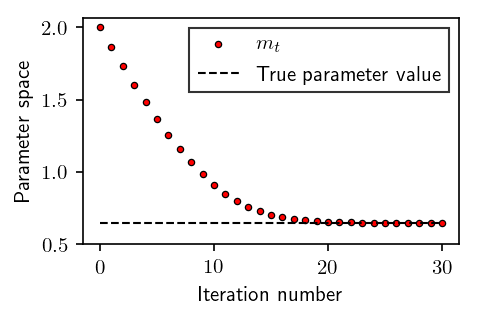

In [42]:
plt.figure(figsize=(3.2360679775, 2))
plt.plot(np.arange(0, ii), mt_update_array, 'o', color='red', markeredgecolor='k', mew=.6, markersize=3., label=r"$m_{t}$")
plt.plot(np.arange(0, ii), nu*np.ones(ii), 'k--', linewidth=1, label=r"True parameter value")
plt.ylim(.5,)
plt.xlabel('Iteration number')
plt.ylabel('Parameter space')
plt.legend(fancybox=False, numpoints=1, edgecolor='k')
plt.savefig('mm.ps', transparent=True, bbox_inches='tight', pad_inches=.1)

## Experimental Variance

In [107]:
import tqdm

In [ ]:
N=100
m_list = np.linspace(1., 20., 10)
var = []
for nu in m_list:
    nsim = 10000
    m_est_list = np.zeros(nsim)
    for n in tqdm.tqdm(range(nsim)):
        mt = np.random.uniform(low=.5, high=20.)
        h = nakagami.rvs(nu=nu, size=N)
        m_est, _ = m_estimator(h, mt)
        m_est_list[n] = m_est
    var.append(np.mean((nu - m_est_list) ** 2))

 99%|█████████▉| 9914/10000 [1:16:22<00:39,  2.16it/s]

## Cramer-Rao lower bound

In [98]:
m = np.linspace(.5, 20., 1000)

In [99]:
crlb = 1/(N * (sps.polygamma(1, m) - 1/m))

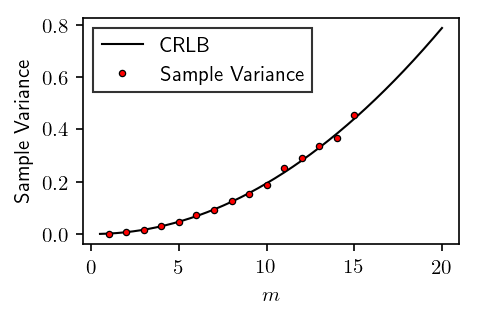

In [100]:
plt.figure(figsize=(3.2360679775, 2))
plt.plot(m, crlb, 'k-', linewidth=1, label=r"CRLB")
plt.plot(m_list, var, 'o', color='red', markeredgecolor='k', mew=.6, markersize=3., label=r"Sample Variance")
plt.xlabel('$m$')
plt.ylabel('Sample Variance')
plt.legend(fancybox=False, numpoints=1, edgecolor='k')
plt.savefig('var_N100.ps', transparent=True, bbox_inches='tight', pad_inches=.1)